In [1]:
%%capture
!pip install twinotter nb_black worldview_dl tqdm

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from intake import open_catalog
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import twinotter.plots
from twinotter.external.eurec4a import add_halo_circle
import twinotter
import worldview_dl
from tqdm.auto import tqdm
from pathlib import Path

import eurec4a

<IPython.core.display.Javascript object>

In [4]:
# cat = eurec4a.get_intake_catalog()
cat = open_catalog(
    "https://raw.githubusercontent.com/leifdenby/eurec4a-intake/twinotter-masin/catalog.yml"
)

<IPython.core.display.Javascript object>

In [5]:
# list the first 10 available files
list(cat.TO.MASIN)[:10]

['TO330_1Hz',
 'TO330_50Hz',
 'TO331_1Hz',
 'TO331_50Hz',
 'TO332_1Hz',
 'TO332_50Hz',
 'TO333_1Hz',
 'TO333_50Hz',
 'TO334_1Hz',
 'TO334_50Hz']

<IPython.core.display.Javascript object>

In [6]:
datasets_1hz = [name for name in cat.TO.MASIN if name.endswith("1Hz")]
datasets_1hz[:5]

['TO330_1Hz', 'TO331_1Hz', 'TO332_1Hz', 'TO333_1Hz', 'TO334_1Hz']

<IPython.core.display.Javascript object>

In [7]:
DATE_FORMAT = "%Y-%m-%d"
TIME_FORMAT = "%H:%M"
BBOX = [-60, -56.5, 12.2, 14.5]  # WESN

<IPython.core.display.Javascript object>

In [8]:
import datetime


def _npdt64_to_datetime(v):
    return v.astype("M8[ms]").astype(datetime.datetime).replace(tzinfo=pytz.utc)


def add_worldview_modis_for_flight(dt_min, dt_max, ax, local_path):
    # bbox: The spatial area to use in the format [S W N E] with units degrees
    bbox_worldview_dl = [BBOX[2], BBOX[0], BBOX[3], BBOX[1]]

    dt_modis_terra = datetime.time(hour=14, minute=30)
    dt_modis_aqua = datetime.time(hour=17, minute=30)

    layers = []
    if dt_min.time() <= dt_modis_terra <= dt_max.time():
        dt_sat = dt_modis_terra
        sat = "MODIS Terra"
        layers.append("MODIS_Terra_CorrectedReflectance_TrueColor")
    elif dt_min.time() <= dt_modis_aqua <= dt_max.time():
        dt_sat = dt_modis_aqua
        sat = "MODIS Aqua"
        layers.append("MODIS_Aqua_CorrectedReflectance_TrueColor")
    else:
        return

    # layers.append("Reference_Labels")

    t = dt_min + 0.5 * (dt_max - dt_min)

    if not Path(local_path).exists():
        worldview_dl.download_image(
            fn=local_path,
            time=t,
            bbox=bbox_worldview_dl,
            layers=layers,
            image_format="tiff",
            resolution=0.01,
        )
    # WESN
    ax.imshow(
        PIL.Image.open(local_path),
        extent=BBOX,
        transform=ccrs.PlateCarree(),
        alpha=1.0,
        zorder=-5,
    )

    ax.annotate(
        f"{sat}\n{dt_sat.strftime(TIME_FORMAT)} UTC",
        (1, 1),
        xytext=(-4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        fontweight="bold",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5),
        ha="right",
        va="top",
    )

<IPython.core.display.Javascript object>

In [9]:
import pytz
import PIL
import matplotlib.ticker as mticker
import numpy as np

<IPython.core.display.Javascript object>

In [10]:
import twinotter.plots

<IPython.core.display.Javascript object>

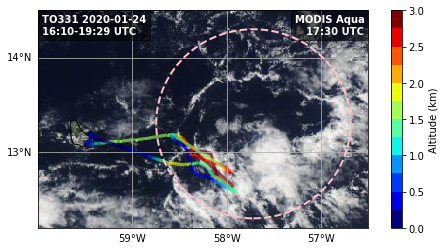

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(8, 4))
fig.suppressComposite = True


def plot_track_with_modis(ds, ax):
    lc = twinotter.plots.colored_line_plot(
        x=ds.LON_OXTS,
        y=ds.LAT_OXTS,
        color=ds.ALT_OXTS / 1000.0,
        ax=ax,
        cmap="jet",
        vmin=0,
        vmax=3.0,
        cmap_steps=3 * 4,
        linewidth=3,
    )

    dt_min = _npdt64_to_datetime(ds.isel(Time=0).Time.values)
    dt_max = _npdt64_to_datetime(ds.isel(Time=-1).Time.values)

    ax.annotate(
        f"TO{ds.flight_number} {dt_min.strftime(DATE_FORMAT)}\n"
        f"{dt_min.strftime(TIME_FORMAT)}-{dt_max.strftime(TIME_FORMAT)} UTC",
        (0, 1),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        fontweight="bold",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5),
        ha="left",
        va="top",
    )

    # twinotter.plots.flight_path(ax=ax, ds=ds, linewidth=3.0, add_cmap=add_colorbar)
    ax.margins(0.2)

    gl = ax.gridlines(draw_labels=["left", "bottom"])
    gl.xlocator = mticker.FixedLocator(np.arange(int(BBOX[0]), BBOX[1], 1.0))
    gl.ylocator = mticker.FixedLocator(np.arange(int(BBOX[2]), BBOX[3], 1.0))
    ax.coastlines()
    add_halo_circle(ax=ax, alpha=1.0, color="pink", linestyle="--", linewidth=2.0)

    path_modis_img = f"worldview_TO{ds.flight_number}.tiff"
    add_worldview_modis_for_flight(
        dt_min=dt_min, dt_max=dt_max, ax=ax, local_path=path_modis_img
    )
    return lc


ds_to = cat.TO.MASIN[datasets_1hz[1]].to_dask()
lc = plot_track_with_modis(ds=ds_to, ax=ax)
cbar = fig.colorbar(lc, ax=ax)
cbar.set_label("Altitude (km)")

# Plot all flights

In [12]:
n_flights = len(datasets_1hz)
n_flights

25

<IPython.core.display.Javascript object>

In [13]:
# plot in 3x5-1=14 + 3*4-1=11 subplot figures to split across two pages
# so that can use bottom-right to fit colorbar


def plot_page(datasets_page):
    n_flights_page = len(datasets_page)
    ncols = 3
    nrows = n_flights_page // ncols
    if nrows * ncols < n_flights_page:
        nrows += 1

    # WESN
    bbox = [-60, -56.5, 12.2, 14.5]
    domain_aspect = (bbox[3] - bbox[2]) / (bbox[1] - bbox[0])
    subfig_width = 5.0

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(subfig_width * ncols + 0.4, subfig_width * domain_aspect * nrows),
        subplot_kw=dict(projection=ccrs.PlateCarree()),
        sharex=True,
        sharey=True,
    )

    axes = axes.flatten()

    for ax, dataset_name in tqdm(zip(axes, datasets_page), total=n_flights_page):
        ds_to = cat.TO.MASIN[dataset_name].to_dask()
        plot_track_with_modis(ds=ds_to, ax=ax)
        if dataset_name == datasets_page[-1]:
            cax = axes[-1].inset_axes(
                [0.0, 0.9, 1.0, 0.1], transform=axes[-1].transAxes
            )
            cbar = fig.colorbar(lc, ax=axes[-1], cax=cax, orientation="horizontal")
            cbar.set_label("Altitude (km)")

        ax.set_extent(bbox, crs=ccrs.PlateCarree())

    axes[-1].axis("off")
    fig.tight_layout()
    plot_fn = f"TO_flightpaths_{datasets_page[0].split('_')[0]}_{datasets_page[-1].split('_')[0]}.png"
    fig.savefig(plot_fn)
    print(f"Saved figure to {plot_fn}")

<IPython.core.display.Javascript object>

  0%|          | 0/11 [00:00<?, ?it/s]

Saved figure to TO_flightpaths_TO344_TO354.png


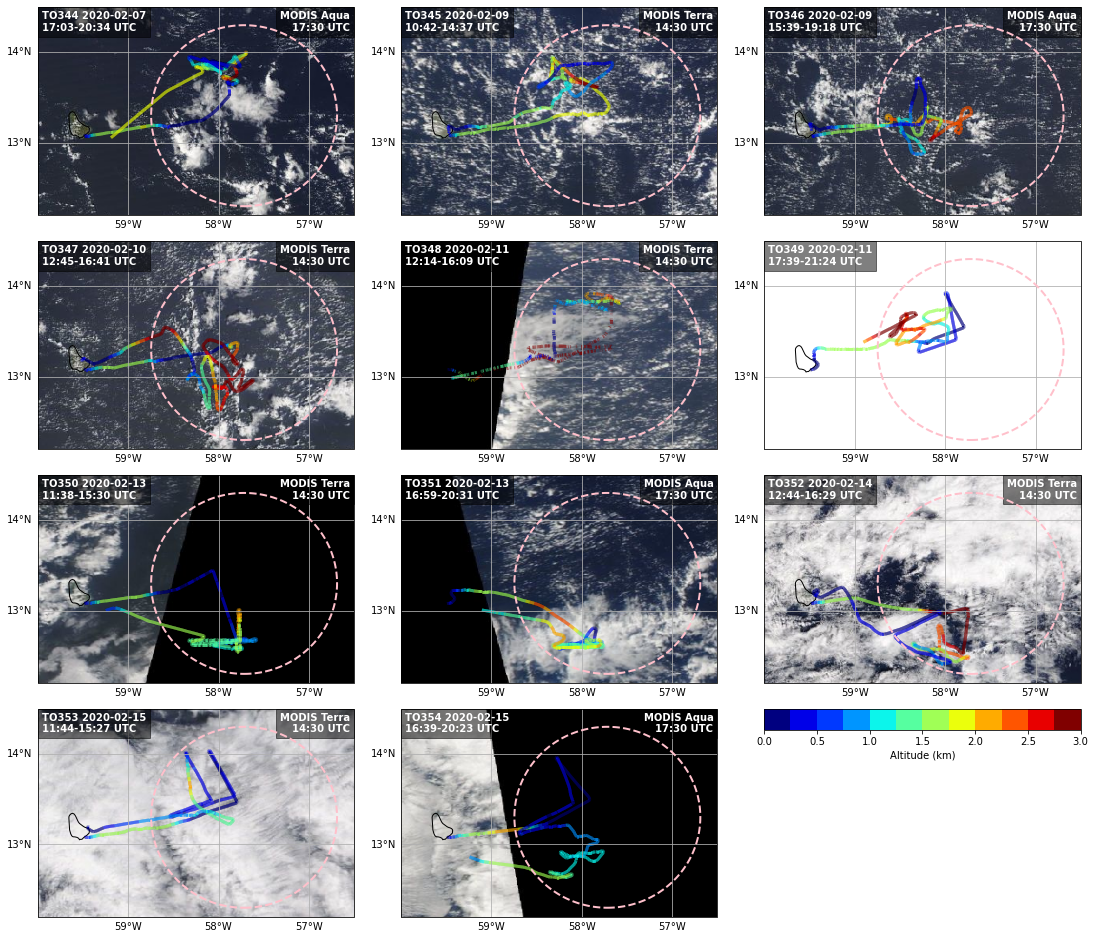

<IPython.core.display.Javascript object>

In [14]:
plot_page(datasets_1hz[14:])

  0%|          | 0/14 [00:00<?, ?it/s]

Saved figure to TO_flightpaths_TO330_TO343.png


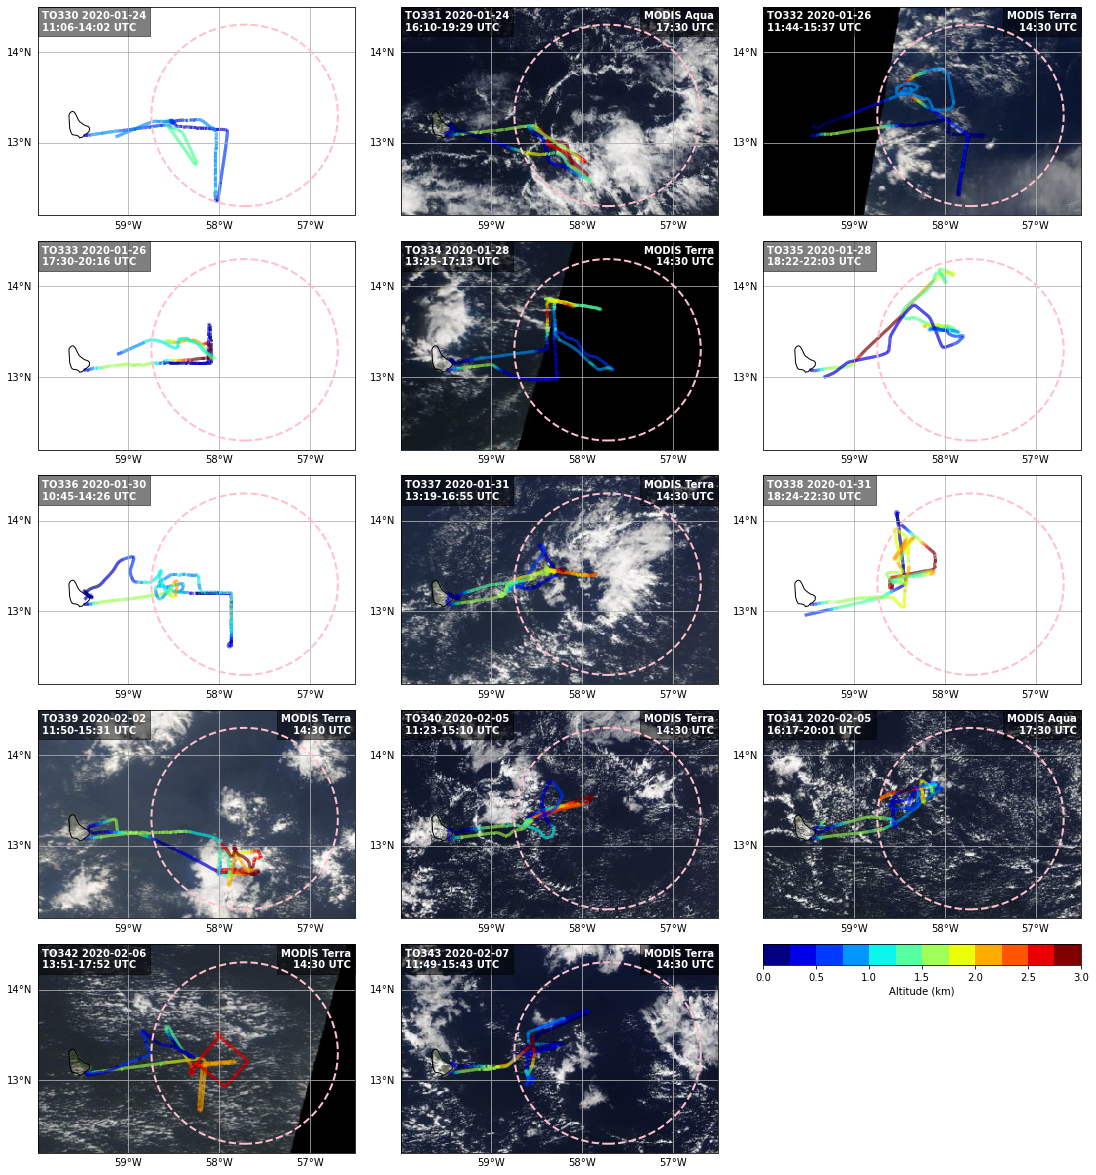

<IPython.core.display.Javascript object>

In [15]:
plot_page(datasets_1hz[:14])

TODO

- [ ] make GOES-16 true-color composites where I don't have MODIS obs
- [ ] write text to explain what I'm doing